This notebook is for hyperparameter optimization on the two basline CNN models: 

    3 x ([Conv --> Batchnorm --> ReLU] x N) --> FC --> Softmax 
    3 x ([Conv --> Batchnorm --> ReLU] x N) --> [Conv --> Batchnorm --> ReLU] x M --> FC --> Softmax

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import ThreeCNN, ThreeCNN_Module 
from train import check_accuracy, train, train_ThreeCNN
from plottingFcts import trainingMetrics, sigBkgEff, plotROC

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=256)

In [3]:
# establish network dimensions 
layer0_params = [1, 3, 3, 1, 1]
layer0_reduce = [1, 3, 93, 1, 1]

layer1_params = [1, 3, 3, 1, 1]
layer1_reduce = [1, 12, 9, 1, 1]

layer2_params = [1, 3, 3, 1, 1]
layer2_reduce = [1, 12, 3, 1, 1]

fc_params = [54, 150, 100, 50, 3, 0.5]

In [14]:
# trying out the module API network
# in this case we use flag = False 
module_test = ThreeCNN_Module(layer0_params, layer0_reduce, layer1_params, layer1_reduce, layer2_params, layer2_reduce, fc_params)

optimizer = optim.Adam(module_test.parameters())

# train the network for one epoch 
hist, bestModel = train(loader_train, loader_val, module_test, optimizer, epochs=25, returnBest=True)


Epoch 1/25:
Iteration 0, loss = 1.1622
cuda
Got 10568 / 30000 correct (35.23)

Iteration 100, loss = 0.5872
cuda
Got 20857 / 30000 correct (69.52)

Iteration 200, loss = 0.4111
cuda
Got 21664 / 30000 correct (72.21)

Iteration 300, loss = 0.4866
cuda
Got 22221 / 30000 correct (74.07)

Iteration 400, loss = 0.5341
cuda
Got 22249 / 30000 correct (74.16)

Iteration 500, loss = 0.4658
cuda
Got 22498 / 30000 correct (74.99)

Iteration 600, loss = 0.4186
cuda
Got 22517 / 30000 correct (75.06)

Iteration 700, loss = 0.4092
cuda
Got 22556 / 30000 correct (75.19)

cuda
Got 135528 / 180000 correct (75.29)
cuda
Got 22580 / 30000 correct (75.27)

Epoch 2/25:
Iteration 0, loss = 0.4570
cuda
Got 22523 / 30000 correct (75.08)

Iteration 100, loss = 0.4342
cuda
Got 22491 / 30000 correct (74.97)

Iteration 200, loss = 0.4007
cuda
Got 22577 / 30000 correct (75.26)

Iteration 300, loss = 0.3989
cuda
Got 22722 / 30000 correct (75.74)

Iteration 400, loss = 0.4326
cuda
Got 22700 / 30000 correct (75.67)

I

Iteration 700, loss = 0.4222
cuda
Got 23184 / 30000 correct (77.28)

cuda
Got 139624 / 180000 correct (77.57)
cuda
Got 23170 / 30000 correct (77.23)

Epoch 14/25:
Iteration 0, loss = 0.3811
cuda
Got 23154 / 30000 correct (77.18)

Iteration 100, loss = 0.4019
cuda
Got 23187 / 30000 correct (77.29)

Iteration 200, loss = 0.4029
cuda
Got 23154 / 30000 correct (77.18)

Iteration 300, loss = 0.4838
cuda
Got 23127 / 30000 correct (77.09)

Iteration 400, loss = 0.4691
cuda
Got 23183 / 30000 correct (77.28)

Iteration 500, loss = 0.4709
cuda
Got 23218 / 30000 correct (77.39)

Iteration 600, loss = 0.4335
cuda
Got 23129 / 30000 correct (77.10)

Iteration 700, loss = 0.4103
cuda
Got 23239 / 30000 correct (77.46)

cuda
Got 139617 / 180000 correct (77.56)
cuda
Got 23189 / 30000 correct (77.30)

Epoch 15/25:
Iteration 0, loss = 0.4295
cuda
Got 23158 / 30000 correct (77.19)

Iteration 100, loss = 0.4289
cuda
Got 23170 / 30000 correct (77.23)

Iteration 200, loss = 0.4004
cuda
Got 23186 / 30000 corre

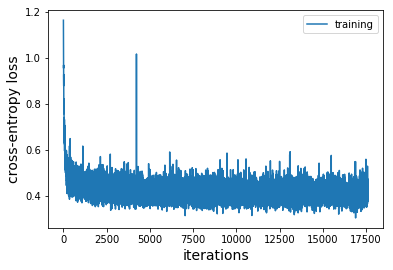

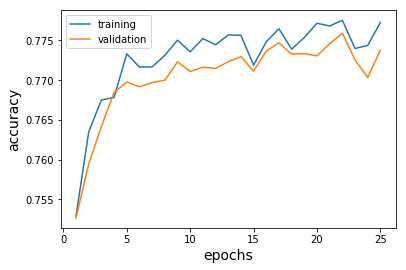

In [15]:
trainingMetrics(hist)

In [ ]:
# get ROC curves for model 
for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(module_test, loader_val, node)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal')
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal')
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal')

The second model, which adds a CNN preprocessing layer between the three initial CNN layers and the fc layer. 

In [16]:
# parameters for the additional CNN layer 
layer3_params = [3, 3, 3, 1, 1]

module_preprocessTest = ThreeCNN_Module(layer0_params, layer0_reduce, layer1_params, layer1_reduce, layer2_params, layer2_reduce, fc_params, layer3_params=layer3_params, flag=True)

optimizer = optim.Adam(module_preprocessTest.parameters())

# train the network for one epoch 
hist, bestModel = train(loader_train, loader_val, module_preprocessTest, optimizer, epochs=25, returnBest=True)


Epoch 1/25:
Iteration 0, loss = 1.1290
cuda
Got 10412 / 30000 correct (34.71)

Iteration 100, loss = 0.5685
cuda
Got 20193 / 30000 correct (67.31)

Iteration 200, loss = 0.5551
cuda
Got 21847 / 30000 correct (72.82)

Iteration 300, loss = 0.4957
cuda
Got 22051 / 30000 correct (73.50)

Iteration 400, loss = 0.4852
cuda
Got 22105 / 30000 correct (73.68)

Iteration 500, loss = 0.5110
cuda
Got 22301 / 30000 correct (74.34)

Iteration 600, loss = 0.5039
cuda
Got 22484 / 30000 correct (74.95)

Iteration 700, loss = 0.4917
cuda
Got 22543 / 30000 correct (75.14)

cuda
Got 135464 / 180000 correct (75.26)
cuda
Got 22589 / 30000 correct (75.30)

Epoch 2/25:
Iteration 0, loss = 0.4748
cuda
Got 22581 / 30000 correct (75.27)

Iteration 100, loss = 0.4373
cuda
Got 22537 / 30000 correct (75.12)

Iteration 200, loss = 0.4248
cuda
Got 22658 / 30000 correct (75.53)

Iteration 300, loss = 0.4726
cuda
Got 22709 / 30000 correct (75.70)

Iteration 400, loss = 0.4627
cuda
Got 22602 / 30000 correct (75.34)

I

Iteration 700, loss = 0.4529
cuda
Got 23129 / 30000 correct (77.10)

cuda
Got 139167 / 180000 correct (77.31)
cuda
Got 23173 / 30000 correct (77.24)

Epoch 14/25:
Iteration 0, loss = 0.4322
cuda
Got 23120 / 30000 correct (77.07)

Iteration 100, loss = 0.4082
cuda
Got 23122 / 30000 correct (77.07)

Iteration 200, loss = 0.4597
cuda
Got 23098 / 30000 correct (76.99)

Iteration 300, loss = 0.4792
cuda
Got 23143 / 30000 correct (77.14)

Iteration 400, loss = 0.3768
cuda
Got 23196 / 30000 correct (77.32)

Iteration 500, loss = 0.4211
cuda
Got 23193 / 30000 correct (77.31)

Iteration 600, loss = 0.4755
cuda
Got 23184 / 30000 correct (77.28)

Iteration 700, loss = 0.4215
cuda
Got 23159 / 30000 correct (77.20)

cuda
Got 139125 / 180000 correct (77.29)
cuda
Got 23154 / 30000 correct (77.18)

Epoch 15/25:
Iteration 0, loss = 0.4268
cuda
Got 23114 / 30000 correct (77.05)

Iteration 100, loss = 0.5333
cuda
Got 23166 / 30000 correct (77.22)

Iteration 200, loss = 0.4911
cuda
Got 23157 / 30000 corre

This additional CNN preprocessing layer performed very slightly better than the original model. Hyperparameter optimization should increase this gap, as will adding more layers to the intermediate layer. 

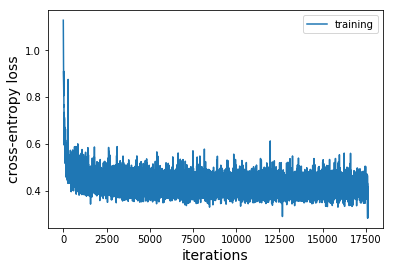

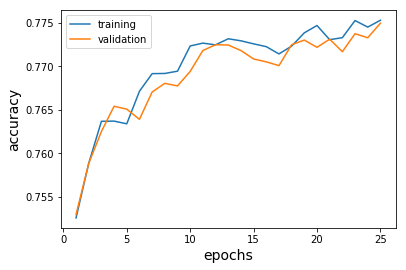

In [17]:
trainingMetrics(hist)